CODE BLOCK: 1


In [ ]:
# Install any required libraries

# !pip install torchsummary

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from tqdm import tqdm

CODE BLOCK: 2


In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


CODE BLOCK: 3


In [ ]:
# Train data transformations
train_transforms = transforms.Compose(
    [
        transforms.RandomApply(
            [
                transforms.CenterCrop(22),
            ],
            p=0.1,
        ),
        transforms.Resize((28, 28)),
        transforms.RandomRotation((-15.0, 15.0), fill=0),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# Test data transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

CODE BLOCK: 4


In [ ]:
train_data = datasets.MNIST(
    "../data", train=True, download=True, transform=train_transforms
)
test_data = datasets.MNIST(
    "../data", train=False, download=True, transform=test_transforms
)

CODE BLOCK: 5


In [ ]:
batch_size = 512

kwargs = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": 2,
    "pin_memory": True,
}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6


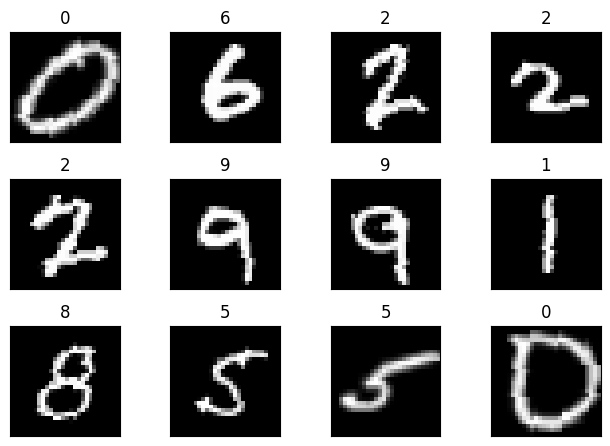

In [ ]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    plt.imshow(batch_data[i].squeeze(0), cmap="gray")
    plt.title(batch_label[i].item())
    plt.xticks([])
    plt.yticks([])

CODE BLOCK: 7


In [ ]:
class Net(nn.Module):
    # This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)  # 28>26 | 1>3 | 1>1
        # print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # 26>24>12 | 3>5>6 | 1>1>2
        # print(x.shape)
        x = F.relu(self.conv3(x), 2)  # 12>10 | 6>10 | 2>2
        # print(x.shape)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))  # 10>8>4 | 10>14>16 | 2>2>4
        # print(x.shape)
        x = x.view(-1, 4096)  # 4*4*256 = 4096
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)

        return F.log_softmax(x, dim=1)

In [ ]:
# Print the model summary by specifying the input size
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

CODE BLOCK: 8


In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {"images": [], "ground_truths": [], "predicted_vals": []}

CODE BLOCK: 8


In [ ]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(
            desc=f"Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(
                output, target, reduction="sum"
            ).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100.0 * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

CODE BLOCK: 9


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}")
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.6410 Batch_id=117 Accuracy=27.28: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]


Test set: Average loss: 1.5709, Accuracy: 4887/10000 (48.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1398 Batch_id=117 Accuracy=86.14: 100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


Test set: Average loss: 0.1478, Accuracy: 9552/10000 (95.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0732 Batch_id=117 Accuracy=95.44: 100%|██████████| 118/118 [00:24<00:00,  4.76it/s]


Test set: Average loss: 0.0741, Accuracy: 9760/10000 (97.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0408 Batch_id=117 Accuracy=96.57: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0604, Accuracy: 9814/10000 (98.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0621 Batch_id=117 Accuracy=97.18: 100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


Test set: Average loss: 0.0488, Accuracy: 9842/10000 (98.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0434 Batch_id=117 Accuracy=97.58: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0436, Accuracy: 9863/10000 (98.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0717 Batch_id=117 Accuracy=97.85: 100%|██████████| 118/118 [00:23<00:00,  5.13it/s]


Test set: Average loss: 0.0402, Accuracy: 9857/10000 (98.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0099 Batch_id=117 Accuracy=98.04: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0360, Accuracy: 9881/10000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0660 Batch_id=117 Accuracy=98.25: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0299, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0475 Batch_id=117 Accuracy=98.31: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0303, Accuracy: 9895/10000 (98.95%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0343 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Test set: Average loss: 0.0345, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0583 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0280, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0812 Batch_id=117 Accuracy=98.63: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0251, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0601 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0236, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0193 Batch_id=117 Accuracy=98.82: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.0282, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0204 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:22<00:00,  5.36it/s]


Test set: Average loss: 0.0220, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0306 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0353 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


Test set: Average loss: 0.0215, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0057 Batch_id=117 Accuracy=99.21: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0246 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0202, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

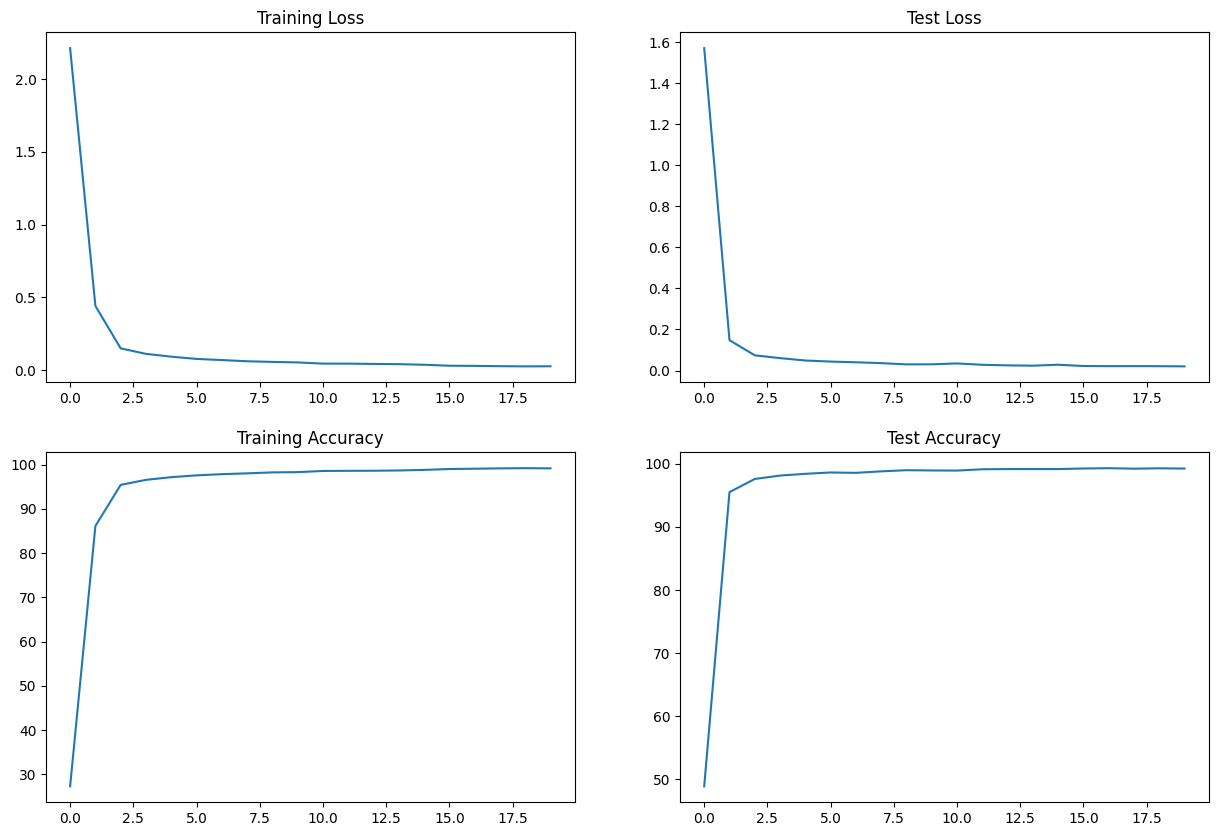

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")